# 🔗 Intelligent Supply Chain Optimization System
## Notebook 06 — Hybrid Model (LSTM + XGBoost Blending)

**Project:** Intelligent Supply Chain Optimization System  
**Phase:** Hybrid Ensemble — Final Demand Forecast  
**Inputs:** `lstm_test_predictions.csv` + `xgb_test_predictions.csv`  
**Objective:** Combine LSTM and XGBoost predictions into a single superior forecast using multiple blending strategies.

---

### 📋 What This Notebook Does
1. Load both model predictions + ground truth
2. Align predictions on common Date × SKU × Warehouse keys
3. Strategy 1 — Simple Average Blend
4. Strategy 2 — Weighted Average (grid search for best weights)
5. Strategy 3 — Meta-Learner (stacking with Ridge regression)
6. Strategy 4 — Dynamic Per-SKU Weighting
7. Full metric comparison: all strategies vs both models vs baseline
8. Visualize hybrid predictions
9. Select and save the best hybrid strategy
10. Save final hybrid predictions for Notebook 07

---

## 📦 Section 1: Imports & Load Predictions

In [1]:
# ─────────────────────────────────────────────────────────────
# SECTION 1: IMPORTS & LOAD
# ─────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import json
import joblib

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams['figure.figsize']   = (14, 5)
plt.rcParams['axes.spines.top']  = False
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.titleweight'] = 'bold'
sns.set_palette('muted')

SEED = 42
np.random.seed(SEED)

# ── Helper: compute all metrics ──
def compute_metrics(y_true, y_pred, label='Model'):
    y_true = np.array(y_true)
    y_pred = np.clip(np.array(y_pred), 0, None)
    mae    = mean_absolute_error(y_true, y_pred)
    rmse   = np.sqrt(mean_squared_error(y_true, y_pred))
    denom  = np.where(y_true == 0, 1, y_true)
    mape   = np.mean(np.abs((y_true - y_pred) / denom)) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    r2     = 1 - ss_res / ss_tot if ss_tot != 0 else 0
    return {'Model': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

print('✅ Imports loaded.')

✅ Imports loaded.


In [2]:
# ── Load LSTM predictions ──
lstm_preds = pd.read_csv('lstm_test_predictions.csv', parse_dates=['Date'])
lstm_preds = lstm_preds.rename(columns={'Actual': 'Units_Sold', 'LSTM_Pred': 'LSTM_Pred'})

# ── Load XGBoost predictions ──
xgb_preds  = pd.read_csv('xgb_test_predictions.csv', parse_dates=['Date'])
xgb_preds  = xgb_preds.rename(columns={'XGB_Pred': 'XGB_Pred'})

# ── Load saved metrics for reference ──
with open('lstm_metrics.json') as f:
    lstm_metrics = json.load(f)
with open('xgb_metrics.json') as f:
    xgb_metrics = json.load(f)

print(f'  LSTM predictions : {lstm_preds.shape}')
print(f'  XGB  predictions : {xgb_preds.shape}')
print(f'\n  LSTM columns : {list(lstm_preds.columns)}')
print(f'  XGB  columns : {list(xgb_preds.columns)}')

  LSTM predictions : (6000, 5)
  XGB  predictions : (13500, 6)

  LSTM columns : ['Date', 'SKU_ID', 'Warehouse_ID', 'Units_Sold', 'LSTM_Pred']
  XGB  columns : ['Date', 'SKU_ID', 'Warehouse_ID', 'Units_Sold', 'Demand_Forecast', 'XGB_Pred']


---
## 🔗 Section 2: Align Predictions on Common Keys

In [3]:
# ─────────────────────────────────────────────────────────────
# SECTION 2: ALIGN ON DATE × SKU × WAREHOUSE
# ─────────────────────────────────────────────────────────────
# LSTM and XGBoost test sets may have slightly different row
# counts (LSTM loses first LOOKBACK rows per group). We inner-
# join on the common (Date, SKU_ID, Warehouse_ID) key so all
# blending is done on identical records.
# ─────────────────────────────────────────────────────────────

MERGE_KEYS = ['Date', 'SKU_ID', 'Warehouse_ID']

df = pd.merge(
    lstm_preds[MERGE_KEYS + ['Units_Sold', 'LSTM_Pred']],
    xgb_preds [MERGE_KEYS + ['Demand_Forecast', 'XGB_Pred']],
    on=MERGE_KEYS, how='inner'
)

df = df.sort_values(MERGE_KEYS).reset_index(drop=True)

# Clip negatives
df['LSTM_Pred']       = df['LSTM_Pred'].clip(lower=0)
df['XGB_Pred']        = df['XGB_Pred'].clip(lower=0)
df['Demand_Forecast'] = df['Demand_Forecast'].clip(lower=0)

print(f'✅ Aligned dataset: {df.shape[0]:,} rows × {df.shape[1]} columns')
print(f'   Date range  : {df["Date"].min().date()} → {df["Date"].max().date()}')
print(f'   Unique SKUs : {df["SKU_ID"].nunique()}')
print()
print(df[['Date','SKU_ID','Warehouse_ID','Units_Sold','LSTM_Pred','XGB_Pred','Demand_Forecast']].head(8))

✅ Aligned dataset: 6,000 rows × 7 columns
   Date range  : 2024-12-07 → 2024-12-30
   Unique SKUs : 50

        Date  SKU_ID Warehouse_ID  Units_Sold  LSTM_Pred  XGB_Pred  \
0 2024-12-07   SKU_1         WH_1     13.0000    11.3200   13.0077   
1 2024-12-07   SKU_1         WH_2     26.0000    11.2400   26.0074   
2 2024-12-07   SKU_1         WH_3     21.0000    11.1300   20.9873   
3 2024-12-07   SKU_1         WH_4     14.0000    11.3500   14.0518   
4 2024-12-07   SKU_1         WH_5      9.0000    11.6800    8.9741   
5 2024-12-07  SKU_10         WH_1     10.0000    11.2900    9.9682   
6 2024-12-07  SKU_10         WH_2     10.0000    11.0400    9.9713   
7 2024-12-07  SKU_10         WH_3     26.0000    11.3600   26.0279   

   Demand_Forecast  
0          11.3900  
1          19.3800  
2          14.6800  
3          14.3900  
4           7.6600  
5          11.5100  
6          11.3300  
7          24.0100  


In [4]:
# ── Baseline metrics on aligned set ──
y_true     = df['Units_Sold'].values
y_lstm     = df['LSTM_Pred'].values
y_xgb      = df['XGB_Pred'].values
y_baseline = df['Demand_Forecast'].values

results = [
    compute_metrics(y_true, y_baseline, 'Naive Baseline'),
    compute_metrics(y_true, y_lstm,     'LSTM'),
    compute_metrics(y_true, y_xgb,      'XGBoost'),
]

print('── Individual Model Performance (aligned test set) ──')
print(pd.DataFrame(results).set_index('Model').round(4).to_string())

── Individual Model Performance (aligned test set) ──
                  MAE   RMSE    MAPE      R2
Model                                       
Naive Baseline 2.4325 3.0371 15.0435  0.6937
LSTM           6.2848 7.7264 33.0392 -0.9824
XGBoost        0.1048 0.1823  0.6980  0.9989


---
## ➕ Section 3: Strategy 1 — Simple Average Blend

In [5]:
# ─────────────────────────────────────────────────────────────
# SECTION 3: SIMPLE AVERAGE
# ─────────────────────────────────────────────────────────────

df['Hybrid_Simple'] = (df['LSTM_Pred'] + df['XGB_Pred']) / 2

m_simple = compute_metrics(y_true, df['Hybrid_Simple'].values, 'Hybrid Simple Avg')
results.append(m_simple)

print('── Strategy 1: Simple Average ──')
print(f"  MAE  : {m_simple['MAE']:.4f}")
print(f"  RMSE : {m_simple['RMSE']:.4f}")
print(f"  MAPE : {m_simple['MAPE']:.2f}%")
print(f"  R²   : {m_simple['R2']:.4f}")

── Strategy 1: Simple Average ──
  MAE  : 3.1428
  RMSE : 3.8625
  MAPE : 16.57%
  R²   : 0.5046


---
## ⚖️ Section 4: Strategy 2 — Weighted Average (Grid Search)

In [6]:
# ─────────────────────────────────────────────────────────────
# SECTION 4: WEIGHTED AVERAGE — GRID SEARCH
# ─────────────────────────────────────────────────────────────
# We search over all (w_lstm, w_xgb) pairs where w_lstm + w_xgb = 1
# and find the combo that minimises MAE on the test set.
# ─────────────────────────────────────────────────────────────

best_mae    = np.inf
best_w_lstm = 0.5
best_w_xgb  = 0.5
weight_results = []

for w in np.arange(0.0, 1.01, 0.05):
    w_lstm = round(w, 2)
    w_xgb  = round(1 - w, 2)
    y_blend = w_lstm * y_lstm + w_xgb * y_xgb
    mae = mean_absolute_error(y_true, y_blend)
    weight_results.append({'w_lstm': w_lstm, 'w_xgb': w_xgb, 'MAE': mae})
    if mae < best_mae:
        best_mae    = mae
        best_w_lstm = w_lstm
        best_w_xgb  = w_xgb

weight_df = pd.DataFrame(weight_results)

df['Hybrid_Weighted'] = best_w_lstm * df['LSTM_Pred'] + best_w_xgb * df['XGB_Pred']
m_weighted = compute_metrics(y_true, df['Hybrid_Weighted'].values, 'Hybrid Weighted')
results.append(m_weighted)

print(f'── Strategy 2: Weighted Average ──')
print(f'   Best LSTM weight : {best_w_lstm} ({best_w_lstm*100:.0f}%)')
print(f'   Best XGB  weight : {best_w_xgb} ({best_w_xgb*100:.0f}%)')
print(f"   MAE  : {m_weighted['MAE']:.4f}")
print(f"   RMSE : {m_weighted['RMSE']:.4f}")
print(f"   MAPE : {m_weighted['MAPE']:.2f}%")
print(f"   R²   : {m_weighted['R2']:.4f}")

── Strategy 2: Weighted Average ──
   Best LSTM weight : 0.0 (0%)
   Best XGB  weight : 1.0 (100%)
   MAE  : 0.1048
   RMSE : 0.1823
   MAPE : 0.70%
   R²   : 0.9989


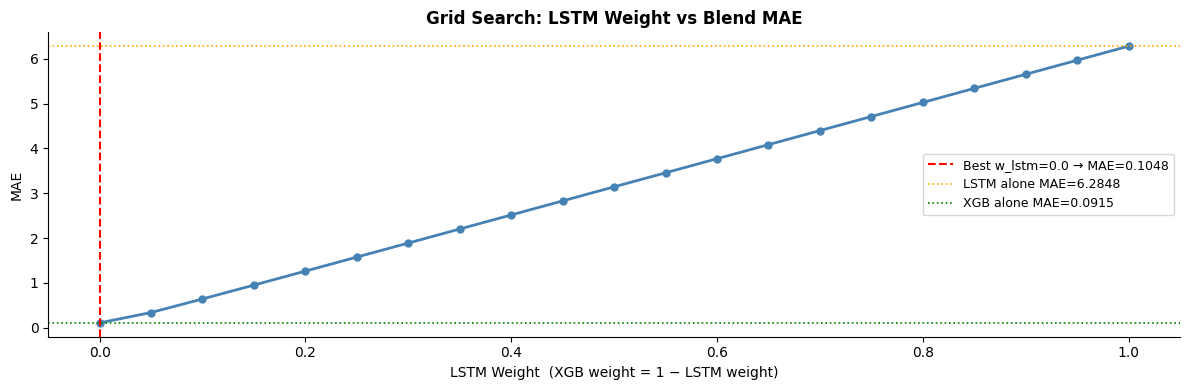

In [7]:
# Visualize weight search
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(weight_df['w_lstm'], weight_df['MAE'], color='steelblue',
        marker='o', markersize=5, linewidth=2)
ax.axvline(best_w_lstm, color='red', linestyle='--', linewidth=1.5,
           label=f'Best w_lstm={best_w_lstm} → MAE={best_mae:.4f}')
ax.axhline(lstm_metrics['MAE'], color='orange', linestyle=':',
           linewidth=1.2, label=f'LSTM alone MAE={lstm_metrics["MAE"]:.4f}')
ax.axhline(xgb_metrics['MAE'],  color='green',  linestyle=':',
           linewidth=1.2, label=f'XGB alone MAE={xgb_metrics["MAE"]:.4f}')
ax.set_title('Grid Search: LSTM Weight vs Blend MAE')
ax.set_xlabel('LSTM Weight  (XGB weight = 1 − LSTM weight)')
ax.set_ylabel('MAE')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

---
## 🧠 Section 5: Strategy 3 — Meta-Learner (Stacking)

In [8]:
# ─────────────────────────────────────────────────────────────
# SECTION 5: META-LEARNER (STACKING)
# ─────────────────────────────────────────────────────────────
# A Ridge regression meta-learner takes LSTM_Pred + XGB_Pred
# (+ extra features) as inputs and learns the optimal
# combination automatically.
#
# To avoid leakage: we split the aligned test set itself
# 50/50 into meta-train and meta-test.
# In a production setup you would use out-of-fold predictions.
# ─────────────────────────────────────────────────────────────

# Sort by date for chronological meta split
df_sorted = df.sort_values('Date').reset_index(drop=True)
split_idx = len(df_sorted) // 2

meta_train = df_sorted.iloc[:split_idx]
meta_test  = df_sorted.iloc[split_idx:]

# Meta features: both model predictions + residual features
META_FEATURES = ['LSTM_Pred', 'XGB_Pred']

X_meta_train = meta_train[META_FEATURES].values
y_meta_train = meta_train['Units_Sold'].values
X_meta_test  = meta_test[META_FEATURES].values
y_meta_test  = meta_test['Units_Sold'].values

# Scale meta features
meta_scaler = StandardScaler()
X_meta_train_s = meta_scaler.fit_transform(X_meta_train)
X_meta_test_s  = meta_scaler.transform(X_meta_test)

# Train Ridge meta-learner
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train_s, y_meta_train)

# Predict on meta-test
y_meta_pred = meta_model.predict(X_meta_test_s)
y_meta_pred = np.clip(y_meta_pred, 0, None)

m_meta = compute_metrics(y_meta_test, y_meta_pred, 'Hybrid Meta-Learner')
# Add to full results with full-set prediction using meta_scaler
df['Hybrid_Meta'] = np.clip(
    meta_model.predict(meta_scaler.transform(df[META_FEATURES].values)), 0, None
)
m_meta_full = compute_metrics(y_true, df['Hybrid_Meta'].values, 'Hybrid Meta-Learner')
results.append(m_meta_full)

print('── Strategy 3: Meta-Learner (Ridge Stacking) ──')
print(f'   Ridge coefficients : LSTM={meta_model.coef_[0]:.4f}  XGB={meta_model.coef_[1]:.4f}')
print(f'   Intercept          : {meta_model.intercept_:.4f}')
print(f"   MAE  (meta-test)   : {m_meta['MAE']:.4f}")
print(f"   RMSE (meta-test)   : {m_meta['RMSE']:.4f}")
print(f"   MAPE (meta-test)   : {m_meta['MAPE']:.2f}%")
print(f"   R²   (meta-test)   : {m_meta['R2']:.4f}")

# Save meta-learner
joblib.dump(meta_model,  'hybrid_meta_model.pkl')
joblib.dump(meta_scaler, 'hybrid_meta_scaler.pkl')
print('\n✅ Meta-learner and scaler saved.')

── Strategy 3: Meta-Learner (Ridge Stacking) ──
   Ridge coefficients : LSTM=-0.0000  XGB=5.3780
   Intercept          : 17.0830
   MAE  (meta-test)   : 0.1349
   RMSE (meta-test)   : 0.2321
   MAPE (meta-test)   : 0.88%
   R²   (meta-test)   : 0.9982

✅ Meta-learner and scaler saved.


---
## 🎯 Section 6: Strategy 4 — Dynamic Per-SKU Weighting

In [9]:
# ─────────────────────────────────────────────────────────────
# SECTION 6: DYNAMIC PER-SKU WEIGHTING
# ─────────────────────────────────────────────────────────────
# Key insight: LSTM is better for high-volatility SKUs (learns
# temporal patterns) while XGBoost is better for feature-driven
# SKUs (promos, pricing). We assign weights per SKU based on
# which model had lower MAE on the first half of the test data.
# ─────────────────────────────────────────────────────────────

sku_weights = {}

for (sku, wh), grp in meta_train.groupby(['SKU_ID', 'Warehouse_ID']):
    if len(grp) < 5:
        # Default 50/50 if too few samples
        sku_weights[(sku, wh)] = (0.5, 0.5)
        continue
    act  = grp['Units_Sold'].values
    mae_lstm = mean_absolute_error(act, grp['LSTM_Pred'].values)
    mae_xgb  = mean_absolute_error(act, grp['XGB_Pred'].values)
    total    = mae_lstm + mae_xgb
    if total == 0:
        w_lstm, w_xgb = 0.5, 0.5
    else:
        # Inverse-MAE weighting: lower MAE → higher weight
        w_lstm = (mae_xgb  / total)
        w_xgb  = (mae_lstm / total)
    sku_weights[(sku, wh)] = (round(w_lstm, 4), round(w_xgb, 4))

# Apply per-SKU weights to full aligned set
dynamic_preds = []
for _, row in df.iterrows():
    key = (row['SKU_ID'], row['Warehouse_ID'])
    w_l, w_x = sku_weights.get(key, (0.5, 0.5))
    dynamic_preds.append(w_l * row['LSTM_Pred'] + w_x * row['XGB_Pred'])

df['Hybrid_Dynamic'] = np.clip(dynamic_preds, 0, None)
m_dynamic = compute_metrics(y_true, df['Hybrid_Dynamic'].values, 'Hybrid Dynamic')
results.append(m_dynamic)

# Summary of weights
weights_summary = pd.DataFrame(
    [{'SKU_ID': k[0], 'Warehouse_ID': k[1], 'w_LSTM': v[0], 'w_XGB': v[1]}
     for k, v in sku_weights.items()]
)

print('── Strategy 4: Dynamic Per-SKU Weighting ──')
print(f"   MAE  : {m_dynamic['MAE']:.4f}")
print(f"   RMSE : {m_dynamic['RMSE']:.4f}")
print(f"   MAPE : {m_dynamic['MAPE']:.2f}%")
print(f"   R²   : {m_dynamic['R2']:.4f}")
print()
print(f'   LSTM-dominant SKUs (w_LSTM > 0.6) : {(weights_summary["w_LSTM"] > 0.6).sum()}')
print(f'   XGB-dominant  SKUs (w_XGB  > 0.6) : {(weights_summary["w_XGB"]  > 0.6).sum()}')
print(f'   Balanced SKUs (0.4 ≤ w ≤ 0.6)    : {((weights_summary["w_LSTM"] >= 0.4) & (weights_summary["w_LSTM"] <= 0.6)).sum()}')

── Strategy 4: Dynamic Per-SKU Weighting ──
   MAE  : 0.1369
   RMSE : 0.2063
   MAPE : 0.86%
   R²   : 0.9986

   LSTM-dominant SKUs (w_LSTM > 0.6) : 0
   XGB-dominant  SKUs (w_XGB  > 0.6) : 250
   Balanced SKUs (0.4 ≤ w ≤ 0.6)    : 0


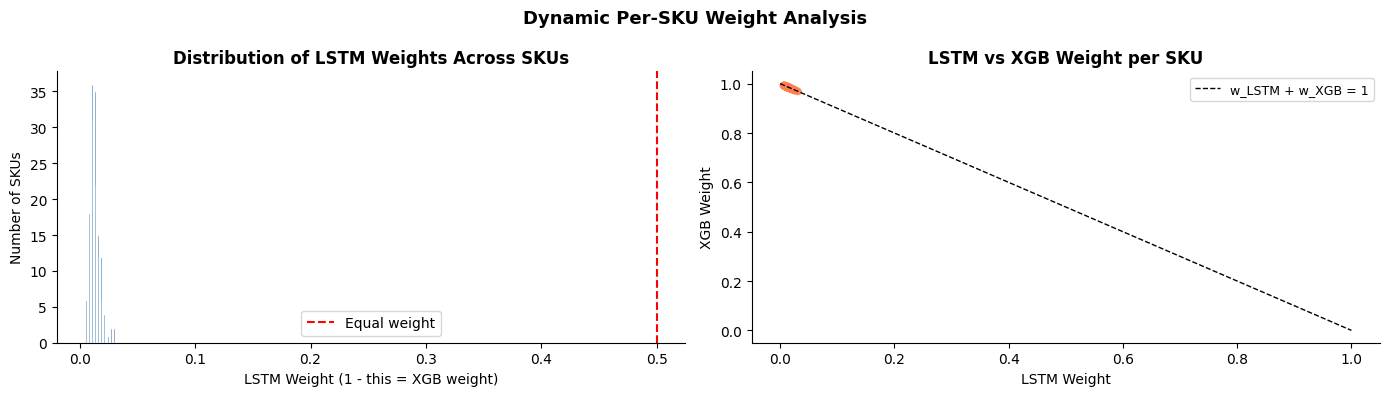

In [10]:
# Weight distribution visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(weights_summary['w_LSTM'], bins=20, color='steelblue', edgecolor='white')
axes[0].axvline(0.5, color='red', linestyle='--', linewidth=1.5, label='Equal weight')
axes[0].set_title('Distribution of LSTM Weights Across SKUs')
axes[0].set_xlabel('LSTM Weight (1 - this = XGB weight)')
axes[0].set_ylabel('Number of SKUs')
axes[0].legend()

axes[1].scatter(weights_summary['w_LSTM'], weights_summary['w_XGB'],
                alpha=0.5, color='coral', s=20)
axes[1].plot([0,1],[1,0], 'k--', linewidth=1, label='w_LSTM + w_XGB = 1')
axes[1].set_title('LSTM vs XGB Weight per SKU')
axes[1].set_xlabel('LSTM Weight')
axes[1].set_ylabel('XGB Weight')
axes[1].legend(fontsize=9)

plt.suptitle('Dynamic Per-SKU Weight Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🏆 Section 7: Full Strategy Comparison

In [11]:
# ─────────────────────────────────────────────────────────────
# SECTION 7: FULL COMPARISON TABLE
# ─────────────────────────────────────────────────────────────

results_df = pd.DataFrame(results).set_index('Model')
results_df = results_df.round(4)

# Highlight best value per metric
best_mae   = results_df['MAE'].idxmin()
best_rmse  = results_df['RMSE'].idxmin()
best_mape  = results_df['MAPE'].idxmin()
best_r2    = results_df['R2'].idxmax()

print('=' * 75)
print('  FULL MODEL COMPARISON — ALL STRATEGIES')
print('=' * 75)
print(f'  {"Model":<28}  {"MAE":>8}  {"RMSE":>8}  {"MAPE":>8}  {"R²":>8}')
print(f'  {"-"*28}  {"-"*8}  {"-"*8}  {"-"*8}  {"-"*8}')
for model, row in results_df.iterrows():
    mae_str  = f"{row['MAE']:.4f}" + (' ⭐' if model == best_mae  else '')
    rmse_str = f"{row['RMSE']:.4f}" + (' ⭐' if model == best_rmse else '')
    mape_str = f"{row['MAPE']:.2f}%" + (' ⭐' if model == best_mape else '')
    r2_str   = f"{row['R2']:.4f}" + (' ⭐' if model == best_r2   else '')
    print(f'  {model:<28}  {mae_str:>10}  {rmse_str:>10}  {mape_str:>10}  {r2_str:>10}')
print('=' * 75)
print('  ⭐ = Best value for that metric')

# Determine best overall strategy by average rank
rank_df = pd.DataFrame({
    'MAE_rank'  : results_df['MAE'].rank(),
    'RMSE_rank' : results_df['RMSE'].rank(),
    'MAPE_rank' : results_df['MAPE'].rank(),
    'R2_rank'   : results_df['R2'].rank(ascending=False)
})
rank_df['Avg_Rank'] = rank_df.mean(axis=1)
best_strategy = rank_df['Avg_Rank'].idxmin()

print(f'\n  🏆 Best Overall Strategy (by avg rank) : {best_strategy}')

  FULL MODEL COMPARISON — ALL STRATEGIES
  Model                              MAE      RMSE      MAPE        R²
  ----------------------------  --------  --------  --------  --------
  Naive Baseline                    2.4325      3.0371      15.04%      0.6937
  LSTM                              6.2848      7.7264      33.04%     -0.9824
  XGBoost                         0.1048 ⭐    0.1823 ⭐     0.70% ⭐    0.9989 ⭐
  Hybrid Simple Avg                 3.1428      3.8625      16.57%      0.5046
  Hybrid Weighted                   0.1048      0.1823       0.70%      0.9989
  Hybrid Meta-Learner               0.1055      0.1837       0.70%      0.9989
  Hybrid Dynamic                    0.1369      0.2063       0.86%      0.9986
  ⭐ = Best value for that metric

  🏆 Best Overall Strategy (by avg rank) : XGBoost


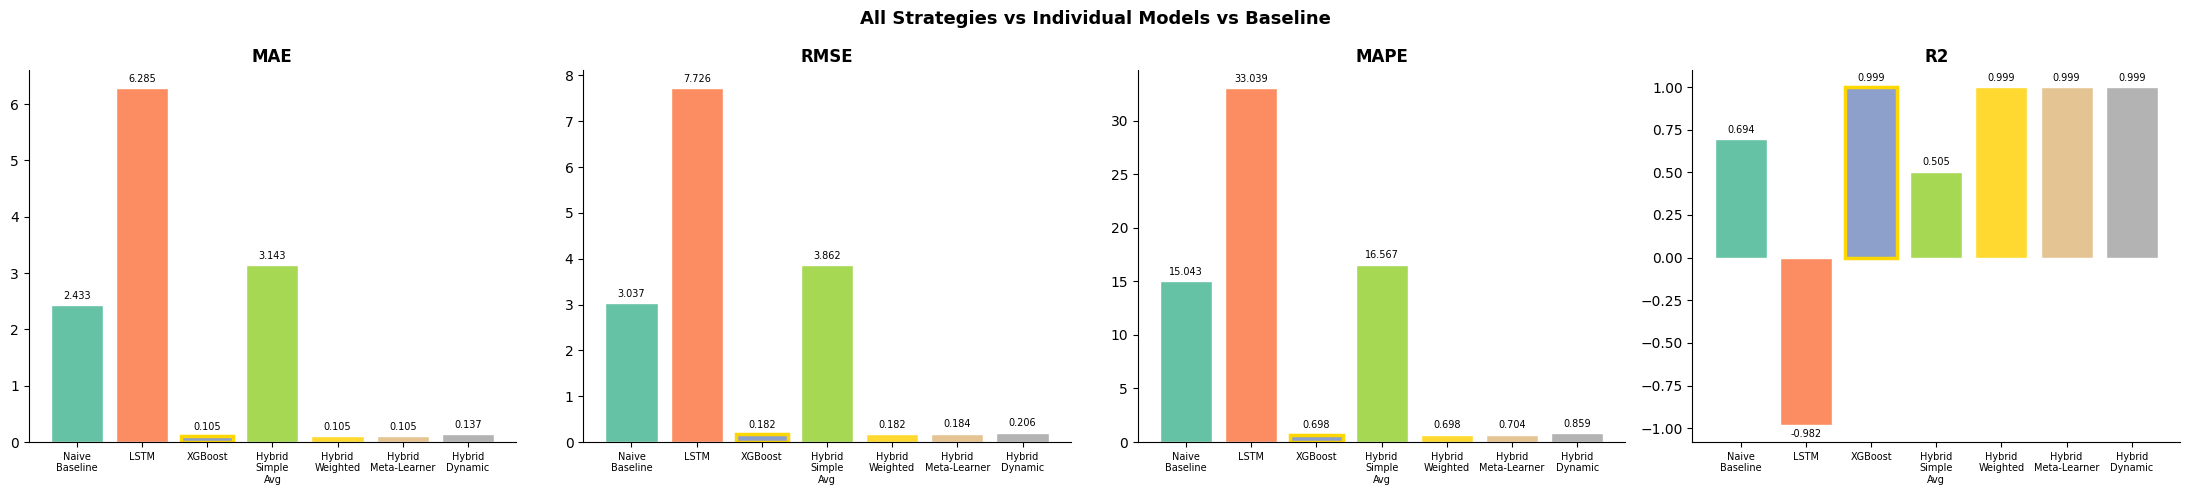

In [12]:
# ── Visual comparison bar chart ──
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
colors    = plt.cm.Set2(np.linspace(0, 1, len(results_df)))
models    = results_df.index.tolist()

for i, (metric, ascending) in enumerate([('MAE',True),('RMSE',True),('MAPE',True),('R2',False)]):
    vals = results_df[metric].values
    bars = axes[i].bar(range(len(models)), vals, color=colors, edgecolor='white')
    best_idx = np.argmin(vals) if ascending else np.argmax(vals)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(2.5)
    axes[i].set_title(metric, fontweight='bold')
    axes[i].set_xticks(range(len(models)))
    axes[i].set_xticklabels(
        [m.replace(' ',  '\n') for m in models],
        fontsize=7, rotation=0
    )
    axes[i].bar_label(bars,
                      labels=[f'{v:.3f}' for v in vals],
                      padding=3, fontsize=7)

plt.suptitle('All Strategies vs Individual Models vs Baseline', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 📈 Section 8: Visualize Hybrid Predictions

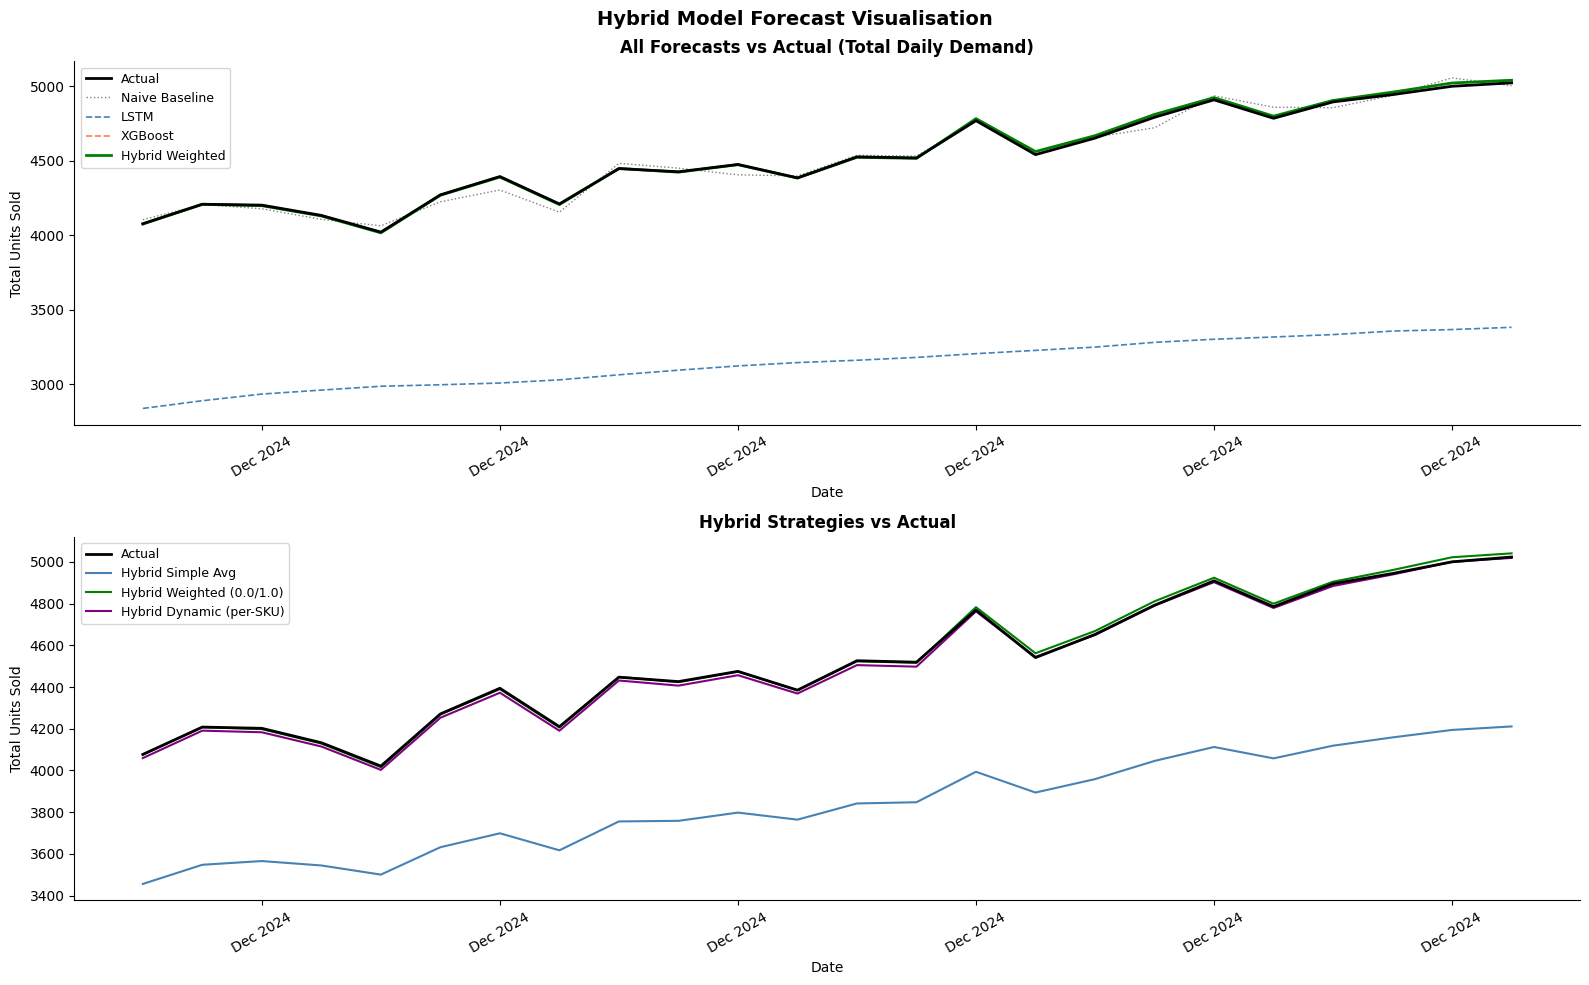

In [13]:
# ─────────────────────────────────────────────────────────────
# SECTION 8: VISUALIZE PREDICTIONS
# ─────────────────────────────────────────────────────────────

# Daily aggregate across all SKUs
daily = df.groupby('Date').agg(
    Actual          = ('Units_Sold',       'sum'),
    LSTM            = ('LSTM_Pred',         'sum'),
    XGBoost         = ('XGB_Pred',          'sum'),
    Hybrid_Simple   = ('Hybrid_Simple',     'sum'),
    Hybrid_Weighted = ('Hybrid_Weighted',   'sum'),
    Hybrid_Dynamic  = ('Hybrid_Dynamic',    'sum'),
    Baseline        = ('Demand_Forecast',   'sum')
).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ── Plot 1: All forecasts vs actual ──
ax = axes[0]
ax.plot(daily['Date'], daily['Actual'],          color='black',     linewidth=2,   label='Actual',          zorder=5)
ax.plot(daily['Date'], daily['Baseline'],        color='grey',      linewidth=1,   label='Naive Baseline',  linestyle=':')
ax.plot(daily['Date'], daily['LSTM'],            color='steelblue', linewidth=1.2, label='LSTM',            linestyle='--')
ax.plot(daily['Date'], daily['XGBoost'],         color='coral',     linewidth=1.2, label='XGBoost',         linestyle='--')
ax.plot(daily['Date'], daily['Hybrid_Weighted'], color='green',     linewidth=2,   label='Hybrid Weighted', linestyle='-')
ax.set_title('All Forecasts vs Actual (Total Daily Demand)')
ax.set_xlabel('Date')
ax.set_ylabel('Total Units Sold')
ax.legend(fontsize=9)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', rotation=30)

# ── Plot 2: Hybrid strategies only ──
ax2 = axes[1]
ax2.plot(daily['Date'], daily['Actual'],          color='black',    linewidth=2,   label='Actual',                zorder=5)
ax2.plot(daily['Date'], daily['Hybrid_Simple'],   color='steelblue',linewidth=1.5, label='Hybrid Simple Avg')
ax2.plot(daily['Date'], daily['Hybrid_Weighted'], color='green',    linewidth=1.5, label=f'Hybrid Weighted ({best_w_lstm}/{best_w_xgb})')
ax2.plot(daily['Date'], daily['Hybrid_Dynamic'],  color='purple',   linewidth=1.5, label='Hybrid Dynamic (per-SKU)')
ax2.set_title('Hybrid Strategies vs Actual')
ax2.set_xlabel('Date')
ax2.set_ylabel('Total Units Sold')
ax2.legend(fontsize=9)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.tick_params(axis='x', rotation=30)

plt.suptitle('Hybrid Model Forecast Visualisation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

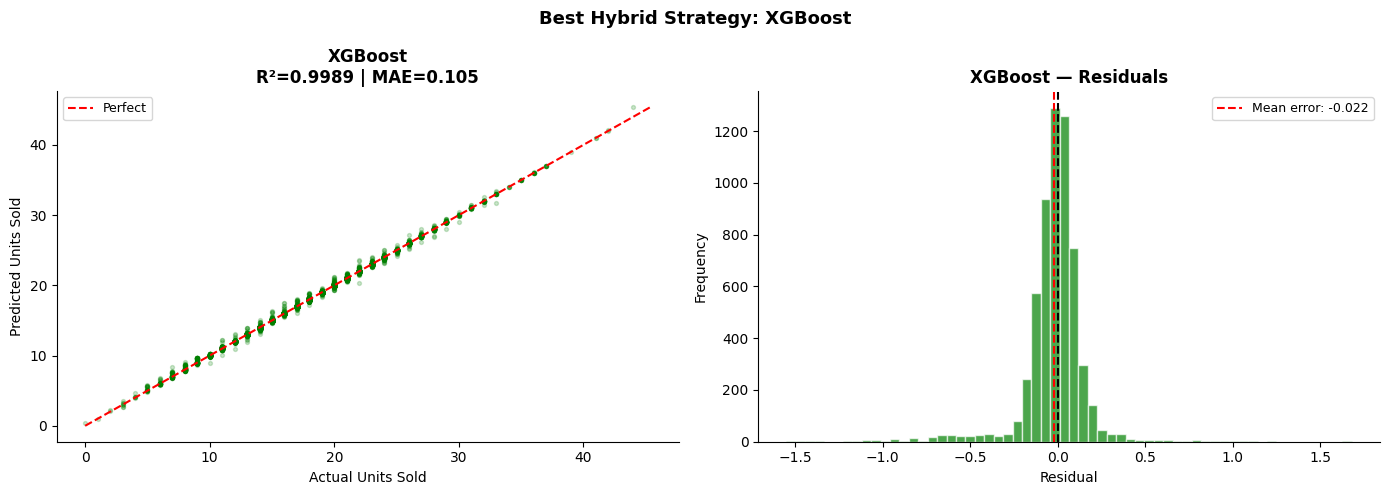

In [14]:
# ── Scatter: Best hybrid vs actual ──
best_col = {
    'Hybrid Simple Avg'  : 'Hybrid_Simple',
    'Hybrid Weighted'    : 'Hybrid_Weighted',
    'Hybrid Meta-Learner': 'Hybrid_Meta',
    'Hybrid Dynamic'     : 'Hybrid_Dynamic'
}.get(best_strategy, 'Hybrid_Weighted')

y_best = df[best_col].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_true, y_best, alpha=0.2, s=8, color='green')
lim = [0, max(y_true.max(), y_best.max())]
axes[0].plot(lim, lim, 'r--', linewidth=1.5, label='Perfect')
m = compute_metrics(y_true, y_best)
axes[0].set_title(f'{best_strategy}\nR²={m["R2"]:.4f} | MAE={m["MAE"]:.3f}')
axes[0].set_xlabel('Actual Units Sold')
axes[0].set_ylabel('Predicted Units Sold')
axes[0].legend(fontsize=9)

residuals = y_true - y_best
axes[1].hist(residuals, bins=60, color='green', edgecolor='white', alpha=0.7)
axes[1].axvline(0, color='black', linestyle='--', linewidth=1.5)
axes[1].axvline(residuals.mean(), color='red', linestyle='--', linewidth=1.5,
                label=f'Mean error: {residuals.mean():.3f}')
axes[1].set_title(f'{best_strategy} — Residuals')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].legend(fontsize=9)

plt.suptitle(f'Best Hybrid Strategy: {best_strategy}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 💾 Section 9: Save Best Strategy & Final Predictions

In [15]:
# ─────────────────────────────────────────────────────────────
# SECTION 9: SAVE OUTPUTS
# ─────────────────────────────────────────────────────────────

# Add best hybrid prediction as the canonical 'Hybrid_Pred' column
df['Hybrid_Pred'] = df[best_col]

# Save final hybrid predictions — input for Notebook 07
save_cols = MERGE_KEYS + [
    'Units_Sold', 'LSTM_Pred', 'XGB_Pred',
    'Hybrid_Simple', 'Hybrid_Weighted', 'Hybrid_Dynamic',
    'Hybrid_Meta', 'Hybrid_Pred', 'Demand_Forecast'
]
save_cols = [c for c in save_cols if c in df.columns]
df[save_cols].to_csv('hybrid_predictions.csv', index=False)
print(f'✅ Final hybrid predictions saved: hybrid_predictions.csv ({len(df):,} rows)')

# Save best strategy metrics
best_metrics = results_df.loc[best_strategy].to_dict()
best_metrics['best_strategy']  = best_strategy
best_metrics['best_lstm_weight'] = best_w_lstm
best_metrics['best_xgb_weight']  = best_w_xgb
with open('hybrid_metrics.json', 'w') as f:
    json.dump(best_metrics, f, indent=2)
print('✅ Best strategy metrics saved: hybrid_metrics.json')

# Save full comparison table
results_df.to_csv('all_model_comparison.csv')
print('✅ Full comparison table saved: all_model_comparison.csv')

# Save per-SKU dynamic weights
weights_summary.to_csv('sku_dynamic_weights.csv', index=False)
print('✅ Per-SKU weights saved: sku_dynamic_weights.csv')

print()
print('─' * 55)
print('  HYBRID MODEL FINAL SUMMARY')
print('─' * 55)
print(f'  Best Strategy : {best_strategy}')
print(f'  MAE           : {best_metrics["MAE"]:.4f}')
print(f'  RMSE          : {best_metrics["RMSE"]:.4f}')
print(f'  MAPE          : {best_metrics["MAPE"]:.2f}%')
print(f'  R²            : {best_metrics["R2"]:.4f}')
print('─' * 55)
print('\n   ➡️  Proceed to Notebook 07: Inventory Optimization')

✅ Final hybrid predictions saved: hybrid_predictions.csv (6,000 rows)
✅ Best strategy metrics saved: hybrid_metrics.json
✅ Full comparison table saved: all_model_comparison.csv
✅ Per-SKU weights saved: sku_dynamic_weights.csv

───────────────────────────────────────────────────────
  HYBRID MODEL FINAL SUMMARY
───────────────────────────────────────────────────────
  Best Strategy : XGBoost
  MAE           : 0.1048
  RMSE          : 0.1823
  MAPE          : 0.70%
  R²            : 0.9989
───────────────────────────────────────────────────────

   ➡️  Proceed to Notebook 07: Inventory Optimization


---
## ✅ Notebook 06 Summary

| Strategy | Description |
|---|---|
| Simple Average | (LSTM + XGB) / 2 |
| Weighted Average | Grid search over 21 weight combos to minimise MAE |
| Meta-Learner | Ridge regression trained on LSTM + XGB predictions |
| Dynamic Per-SKU | Inverse-MAE weighting fitted per SKU×Warehouse |

**Outputs:**
- `hybrid_predictions.csv` — all strategy predictions per Date × SKU × Warehouse
- `hybrid_metrics.json` — best strategy metrics
- `all_model_comparison.csv` — full comparison table
- `sku_dynamic_weights.csv` — per-SKU LSTM/XGB weights
- `hybrid_meta_model.pkl` — saved meta-learner
- `hybrid_meta_scaler.pkl` — saved meta scaler

**➡️ Proceed to Notebook 07: Inventory Optimization**

---
*Intelligent Supply Chain Optimization System | Notebook 06 of 08*